## Evolving gaussians experiments

In [1]:
%cd evolving_gaussians

/users/eleves-b/2020/basile.terver/Spatio-temporal-alignments/spatio-temporal-alignements/evolving_gaussians


/Data/basile-terver/venvs/.venv_sta/lib64/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_gaussian_mixture_data(num_samples_per_class=5, num_timesteps=250, support_size=150, num_gaussians=[1, 3], evolution_types=["linear", "circular"], speeds=[1.0, -1.0], seed=None):
    np.random.seed(seed)
    
    # Generate time values, time normalized in [0,1] interval
    time_values = np.linspace(0, 1, num_timesteps)

    # Initialize data array
    num_classes = len(evolution_types) * len(speeds) * len(num_gaussians)
    data = np.zeros((num_classes, num_samples_per_class, num_timesteps, support_size))

    # Initialize label arrays
    y_speed = []
    y_evotype = []
    y_numgaussians = []

    for speed_idx, speed in enumerate(speeds):
        for evolution_idx, evolution_type in enumerate(evolution_types):
            for num_gaussian_idx, num_gaussian in enumerate(num_gaussians):
                for sample_idx in range(num_samples_per_class):
                    means = np.random.uniform(0, support_size, num_gaussian)
                    std_devs = np.random.uniform(5, 20, num_gaussian)

                    # Assign labels based on the current configuration
                    y_speed.append(speed)
                    y_evotype.append(evolution_type)
                    y_numgaussians.append(num_gaussian)

                    for t, time in enumerate(time_values):
                        # Update means based on movement
                        if evolution_type == "linear":
                            means += speed
                        elif evolution_type == "circular":
                            means = (means + speed) % support_size
                        else:
                            raise ValueError("Invalid evolution_type. Use 'linear' or 'circular'.")
                        
                        # Evaluate Gaussian mixture PDF at each point in the support for each component
                        component_pdfs = norm.pdf(np.arange(support_size)[:, None], loc=means, scale=std_devs)
                        
                        # Sum the probabilities across components
                        mixture_pdf = np.sum(component_pdfs, axis=1)
                        class_idx = (speed_idx * len(evolution_types) + evolution_idx) * len(num_gaussians) + num_gaussian_idx
                        data[class_idx, sample_idx, t, :] = mixture_pdf / np.sum(mixture_pdf)

    return data,y_speed, y_evotype, y_numgaussians


In [3]:
def plot_samples(data, num_snapshots=5, samples_per_class_to_plot=1, y_speed=None, y_evotype=None, y_numgaussians=None):
    num_classes, num_samples_per_class, num_timesteps, support_size = data.shape
    snapshot_indices = np.linspace(0, num_timesteps - 1, num_snapshots, dtype=int)

    plt.figure(figsize=(15, 7 * num_classes))

    for class_idx in range(num_classes):
        
        for plot_sample_idx in range(samples_per_class_to_plot):
            sample_idx = np.random.randint(0, num_samples_per_class)  # Randomly select a sample to plot
            plt.subplot(num_classes * samples_per_class_to_plot, 1, class_idx * samples_per_class_to_plot + plot_sample_idx + 1)
            title = f"Class {class_idx + 1}, Plotted Sample {plot_sample_idx + 1}"
            # Include labels in the title if provided
            if y_speed is not None:
                title += f", Speed: {y_speed[class_idx*num_samples_per_class]}"
            if y_evotype is not None:
                title += f", Evolution Type: {y_evotype[class_idx*num_samples_per_class]}"
            if y_numgaussians is not None:
                title += f", Num Gaussians: {y_numgaussians[class_idx*num_samples_per_class]}"
            plt.title(title)

            for snapshot_idx in snapshot_indices:
                plt.plot(data[class_idx, sample_idx, snapshot_idx, :].T, label=f"Snapshot {snapshot_idx + 1}")

            plt.legend()

    plt.tight_layout()
    plt.show()




In the parameters we set below, we could not do more than 100 timesteps and a support size of 100 without running out of memory. 

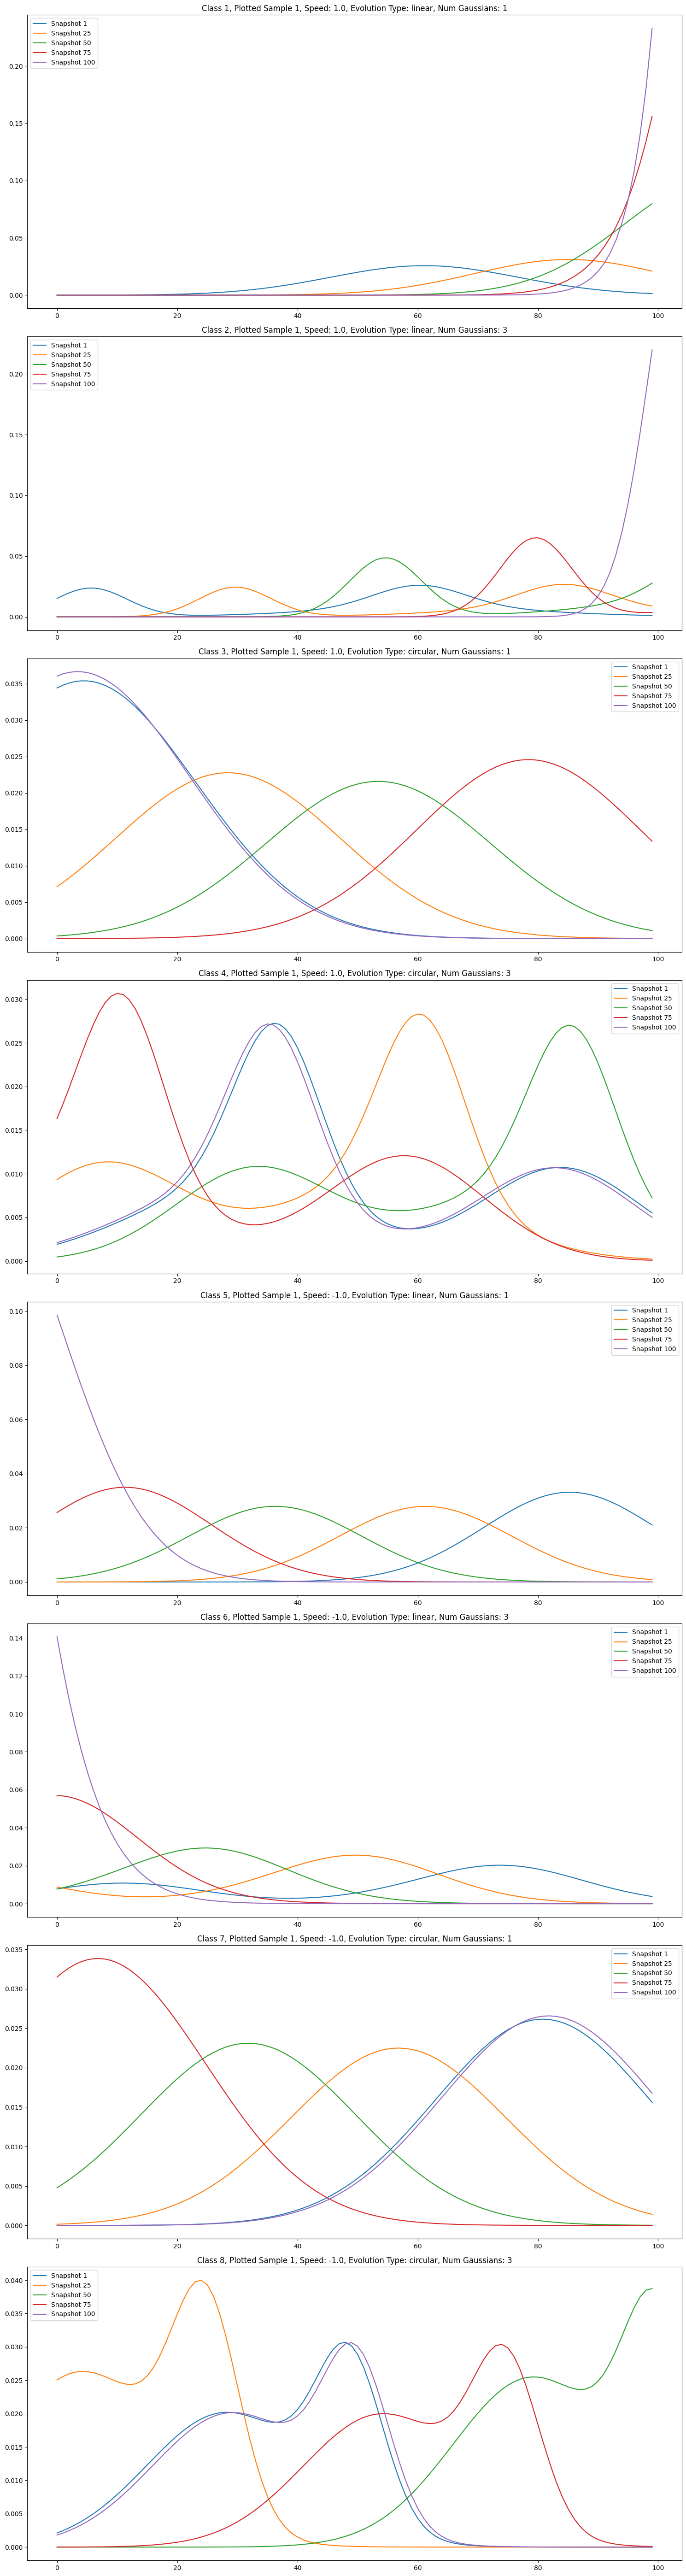

In [4]:
# Example usage with the labels
num_samples_per_class=5
num_timesteps=100
support_size=100
num_gaussians=[1, 3]
evolution_types=["linear", "circular"]
speeds=[1.0, -1.0]
seed = 42

data,y_speed, y_evotype, y_numgaussians = generate_gaussian_mixture_data(\
    num_samples_per_class,num_timesteps,support_size,num_gaussians,evolution_types,speeds,seed=seed)
plot_samples(data, num_snapshots=5, y_speed=y_speed, y_evotype=y_evotype, y_numgaussians=y_numgaussians)

In [5]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
from sta import sta_matrix, sdtw_matrix

In [6]:
def compute_distance_matrix_abs_distance(support_size):
    # Assuming you want the pairwise distances between the points in the support
    support_points = np.arange(support_size).reshape(-1, 1)
    distance_matrix = np.abs(support_points - support_points.T)
    return distance_matrix

In [7]:
# Modify depending on your hardware
n_gpu_devices = 1

In [10]:
def run_tsne_gaussians(data,y_speed, y_evotype, y_numgaussians,num_gaussians,\
                    evolution_types,speeds,betas=[0,0.1],epsilon=0.2,gamma=1.):
    
    # to avoid numerical errors with Sinkhorn, add 1e-3
    data = data + 1e-3
    num_classes, num_samples_per_class, num_timesteps, support_size = data.shape

    # Reshape data to match the expected shape
    data_reshaped = data.reshape(num_classes * num_samples_per_class, num_timesteps, support_size)

    experiment = dict(
        gaussian_data=data,
        y_speed=y_speed,
        y_evotype=y_evotype,
        y_numgaussians=y_numgaussians,
        betas=betas)
    M_=compute_distance_matrix_abs_distance(support_size)
    M = M_ / np.median(M_)
    K = np.exp(- M / epsilon)

    print('----Gaussian mixture signals are the training data for t-SNE-----')
    print('n_samples=', num_classes*num_samples_per_class)
    print('num_timesteps=', num_timesteps)
    print('dimension=', support_size)
    print('-------------------------------------')

    params = dict(K=K,epsilon=epsilon, gamma=gamma, n_jobs=4, n_gpu_devices=1)

    # Clear GPU memory
    # torch.cuda.empty_cache()

    # Compute STA distance matrix
    print('-----Starting sta_matrix computation-------')
    precomputed = sta_matrix(data_reshaped, betas, **params)
    print('-----sta_matrix computed -------')
    print('precomputed sta_matrix has shape', precomputed.shape)

    # Clear GPU memory
    # torch.cuda.empty_cache()

    experiment["sta"] = dict()
    for beta, train_ in zip(betas, precomputed):
        train = train_.copy()
        # Shift the distance to avoid negative values with large betas
        train -= train.min()
        tsne_data = TSNE(metric="precomputed", perplexity=30, init='random').fit_transform(train)
        experiment["sta"][beta] = tsne_data

    method = "soft"
    experiment["soft"] = dict()
    for beta in betas:
        precomputed = sdtw_matrix(data_reshaped, beta, n_jobs=10)
        train = precomputed.copy()
        # Shift the distance to avoid negative values with large betas
        train -= train.min()
        tsne_data = TSNE(metric="precomputed", perplexity=30, init='random').fit_transform(train)
        experiment[method][beta] = tsne_data

    expe_filename = f"data/tsne-gaussians_ns{num_samples_per_class}_nt{num_timesteps}_b{'_'.join(map(str, betas))}_s{'_'.join(map(str, speeds))}_ng{'_'.join(map(str, num_gaussians))}_{'_'.join(map(str, evolution_types))}.pkl"
    with open(expe_filename, "wb") as expe_file:
        pickle.dump(experiment, expe_file)


In [32]:
betas=[0,0.1]
epsilon=0.2
gamma=1.
run_tsne_gaussians(data,y_speed, y_evotype, y_numgaussians,num_gaussians,\
                    evolution_types,speeds,betas=betas,epsilon=epsilon,gamma=gamma)

----Gaussian mixture signals are the training data for t-SNE-----
n_samples= 40
num_timesteps= 100
dimension= 100
-------------------------------------
-----Starting sta_matrix computation-------
Doing 0 / 40 ...
Doing 39 / 40 ...
Doing 1 / 40 ...
Doing 38 / 40 ...


Doing 2 / 40 ...
Doing 37 / 40 ...
Doing 3 / 40 ...
Doing 36 / 40 ...
Doing 4 / 40 ...
Doing 35 / 40 ...
Doing 5 / 40 ...
Doing 34 / 40 ...
Doing 6 / 40 ...
Doing 33 / 40 ...
Doing 7 / 40 ...
Doing 32 / 40 ...
Doing 8 / 40 ...
Doing 31 / 40 ...
Doing 9 / 40 ...
Doing 30 / 40 ...
Doing 10 / 40 ...
Doing 29 / 40 ...
Doing 11 / 40 ...
Doing 28 / 40 ...
Doing 12 / 40 ...
Doing 27 / 40 ...
Doing 13 / 40 ...
Doing 26 / 40 ...
Doing 14 / 40 ...
Doing 25 / 40 ...
Doing 15 / 40 ...
Doing 24 / 40 ...
Doing 16 / 40 ...
Doing 23 / 40 ...
Doing 17 / 40 ...
Doing 22 / 40 ...
Doing 18 / 40 ...
Doing 21 / 40 ...
Doing 19 / 40 ...
Doing 20 / 40 ...
-----sta_matrix computed -------
precomputed sta_matrix has shape (2, 40, 40)
Softdtw out of 6
Softdtw out of 2
Softdtw out of 8
Softdtw out of 10
Softdtw out of 11
Softdtw out of 12
Softdtw out of 13
Softdtw out of 14
Softdtw out of 15
Softdtw out of 16
Softdtw out of 17
Softdtw out of 18
Softdtw out of 20
Softdtw out of 21
Softdtw out of 19
Softdtw out of 

In [8]:
def get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types):
    return "tsne-gaussians_ns{}_nt{}_b{}_s{}_ng{}_{}.pkl".format(
        num_samples_per_class, num_timesteps, "_".join(map(str, betas)),
        "_".join(map(str, speeds)), "_".join(map(str, num_gaussians)),
        "_".join(map(str, evolution_types))
    )

In [41]:
from matplotlib import pyplot as plt
import pickle
import numpy as np
from matplotlib.lines import Line2D

def plot_tsne_results(data, num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types):
    fontsize = 11
    params = {'axes.labelsize': fontsize + 2,
              'font.size': fontsize,
              'legend.fontsize': fontsize + 1,
              'xtick.labelsize': fontsize,
              'ytick.labelsize': fontsize,
              'pdf.fonttype': 42}
    plt.rcParams.update(params)

    expe_filename = get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types)
    data_expe_filename = f'data/{expe_filename}'
    fig_expe_filename_png = f'fig/{expe_filename.replace(".pkl", ".png")}'

    print('------filename of the figures of the experiment to copy in the plot cell below-----')
    print(fig_expe_filename_png)
    print('-------------------------------------')

    expe_file = open(data_expe_filename, "rb")
    experiment = pickle.load(expe_file)

    y_speed = experiment["y_speed"]
    speed_mapping = {speed: idx for idx, speed in enumerate(sorted(set(speeds)))}

    y_evotype = experiment["y_evotype"]
    evotype_mapping = {'linear': 0, 'circular': 1}

    y_numgaussians = experiment["y_numgaussians"]

    methods = ["soft", "sta"]

    color_base = np.array(["indianred", "cornflowerblue"])
    colors = color_base[np.array([speed_mapping[speed] for speed in y_speed])]

    marker_base = np.array(["+", "o"])
    markers = np.array([marker_base[evotype_mapping[evotype]] for evotype in y_evotype])

    alpha_base=[0.4,0.8]
    alphas = [0.4 if num_gaussian == 1 else 0.8 for num_gaussian in y_numgaussians]

    titles = ["Soft-DTW", "STA"]
    
    color_names = ["Speed 1.0", "Speed -1.0"]
    marker_names = ["Evolution type linear", "Evolution type circular"]
    num_gaussians_names = ["1 Gaussian", "3 Gaussians"]

    legend_entries = []
    for color, color_name in zip(color_base, color_names):
        for marker, marker_name in zip(marker_base, marker_names):
            for alpha, num_gaussians_name in zip(alpha_base, num_gaussians_names):
                label = f"{color_name}, {marker_name}, {num_gaussians_name} (Alpha {alpha:.2f})"
                if marker == "+":
                    marker_symbol = r"$\oplus$"
                else:
                    marker_symbol = marker
                legend_entries.append(Line2D([0], [0], color="w", markerfacecolor=color, marker=marker_symbol, alpha=alpha,
                                label=label, markersize=12))

    f, axes = plt.subplots(2, 2, figsize=(12, 10))

    for j, beta in enumerate(betas):
        for i, (method, title) in enumerate(zip(methods, titles)):
            method_data = experiment[method]
            tsne_data = method_data[beta]
            ax = axes[j, i]
            for point, color, marker, alpha in zip(tsne_data, colors, markers, alphas):
                ax.scatter(point[0], point[1], color=color, s=60, marker=marker, alpha=alpha)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_ylabel(r"$\beta = %s$" % (np.round(beta, 1)))
            if j == 0:
                ax.set_title(title)

    # ax.legend(handles=legend_entries, loc=2, ncol=1, bbox_to_anchor=[1.05, 1.0])
    ax.legend(handles=legend_entries, loc="upper left", bbox_to_anchor=(1, 1), title="Legend", frameon=False)

    # Save only in PNG format
    plt.savefig(fig_expe_filename_png, bbox_inches='tight')
    plt.show()


------filename of the figures of the experiment to copy in the plot cell below-----
fig/tsne-gaussians_ns5_nt100_b0_0.1_s1.0_-1.0_ng1_3_linear_circular.png
-------------------------------------


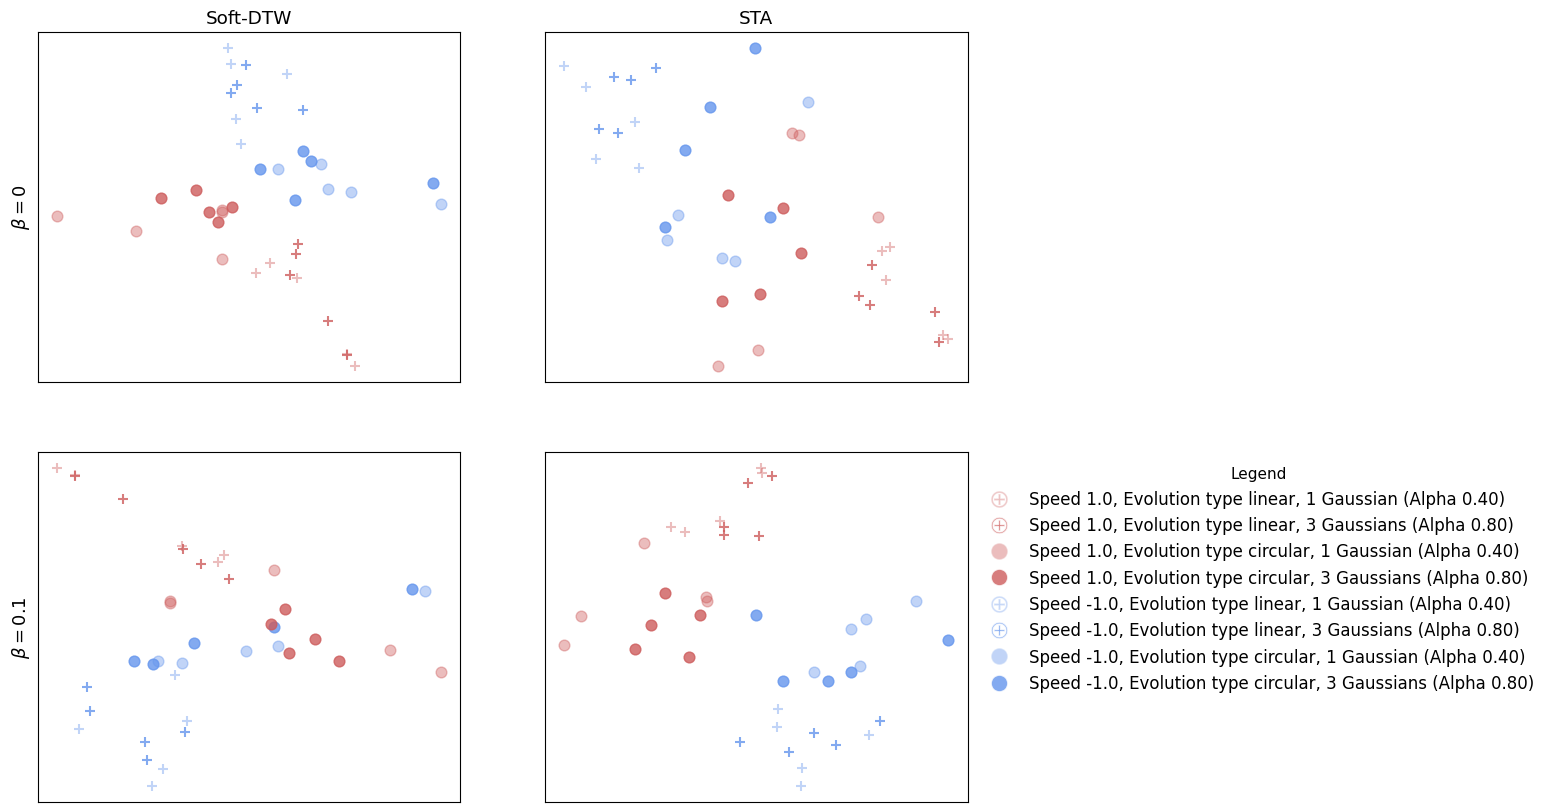

In [42]:
plot_tsne_results(data, num_samples_per_class,\
  num_timesteps, [0, 0.1], speeds, num_gaussians, evolution_types)

In [43]:
from matplotlib import pyplot as plt
import pickle
import numpy as np
from matplotlib.lines import Line2D

def plot_tsne_results(data, num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types):
    fontsize = 11
    params = {'axes.labelsize': fontsize + 2,
              'font.size': fontsize,
              'legend.fontsize': fontsize + 1,
              'xtick.labelsize': fontsize,
              'ytick.labelsize': fontsize,
              'pdf.fonttype': 42}
    plt.rcParams.update(params)

    expe_filename = get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types)
    data_expe_filename = f'data/{expe_filename}'
    fig_expe_filename_png = f'fig/{expe_filename.replace(".pkl", ".png")}'

    print('------filename of the figures of the experiment to copy in the plot cell below-----')
    print(fig_expe_filename_png)
    print('-------------------------------------')

    expe_file = open(data_expe_filename, "rb")
    experiment = pickle.load(expe_file)

    y_speed = experiment["y_speed"]
    print('y_speed:', y_speed)  
    speed_mapping = {speed: idx for idx, speed in enumerate(sorted(set(speeds)))}

    y_evotype = experiment["y_evotype"]
    print('y_evotype:',y_evotype)
    evotype_mapping = {'linear': 0, 'circular': 1}

    y_numgaussians = experiment["y_numgaussians"]
    print('y_numgaussians:',y_numgaussians)

    methods = ["soft", "sta"]
    
    color_base = np.array(["indianred", "cornflowerblue"])
    colors = color_base[np.array([speed_mapping[speed] for speed in y_speed])]

    marker_base = np.array(["+", "o"])
    markers = np.array([marker_base[evotype_mapping[evotype]] for evotype in y_evotype])

    titles = ["Soft-DTW", "STA"]
    color_names = ["Speed 1.0", "Speed -1.0"]
    marker_names = ["Evolution type linear", "Evolution type circular"]

    # Third label for number of Gaussians
    num_gaussians_names = ["Num Gaussians 1", "Num Gaussians 3"]

    legend_colors = [Line2D([0], [0], color="w", markerfacecolor=color, marker="s", label=name, markersize=12,)
                     for color, name in zip(color_base, color_names)]
    legend_marker = [Line2D([0], [0], color="w", markerfacecolor="k", markeredgecolor="k", linewidth=2,
                     marker=marker, markersize=12, label=name)
                     for marker, name in zip(marker_base, marker_names)]
    legend_num_gaussians = [Line2D([0], [0], color="w", markerfacecolor="k", markeredgecolor="k", linewidth=2,
                           marker=marker, markersize=12, label=name)
                           for marker, name in zip(marker_base, num_gaussians_names)]

    legend_colors.extend(legend_marker)
    legend_colors.extend(legend_num_gaussians)

    f, axes = plt.subplots(2, 2, figsize=(10, 8))

    for j, beta in enumerate(betas):
        for i, (method, title) in enumerate(zip(methods, titles)):
            method_data = experiment[method]
            tsne_data = method_data[beta]
            ax = axes[j, i]
            for point, color, marker, num_gaussian in zip(tsne_data, colors, markers, y_numgaussians):
                alpha = 0.4 if num_gaussian == 1 else 0.8  # Adjust alpha based on the number of Gaussians
                ax.scatter(point[0], point[1], color=color, s=60, marker=marker, alpha=alpha)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_ylabel(r"$\beta = %s$" % (np.round(beta, 1)))
            if j == 0:
                ax.set_title(title)

    ax.legend(handles=legend_colors, loc=2, ncol=2, bbox_to_anchor=[1.05, 1.0])

    # Save only in PNG format
    plt.savefig(fig_expe_filename_png, bbox_inches='tight')
    plt.show()


------filename of the figures of the experiment to copy in the plot cell below-----
fig/tsne-gaussians_ns5_nt100_b0_0.1_s1.0_-1.0_ng1_3_linear_circular.png
-------------------------------------
y_speed: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
y_evotype: ['linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular', 'circular']
y_numgaussians: [1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3,

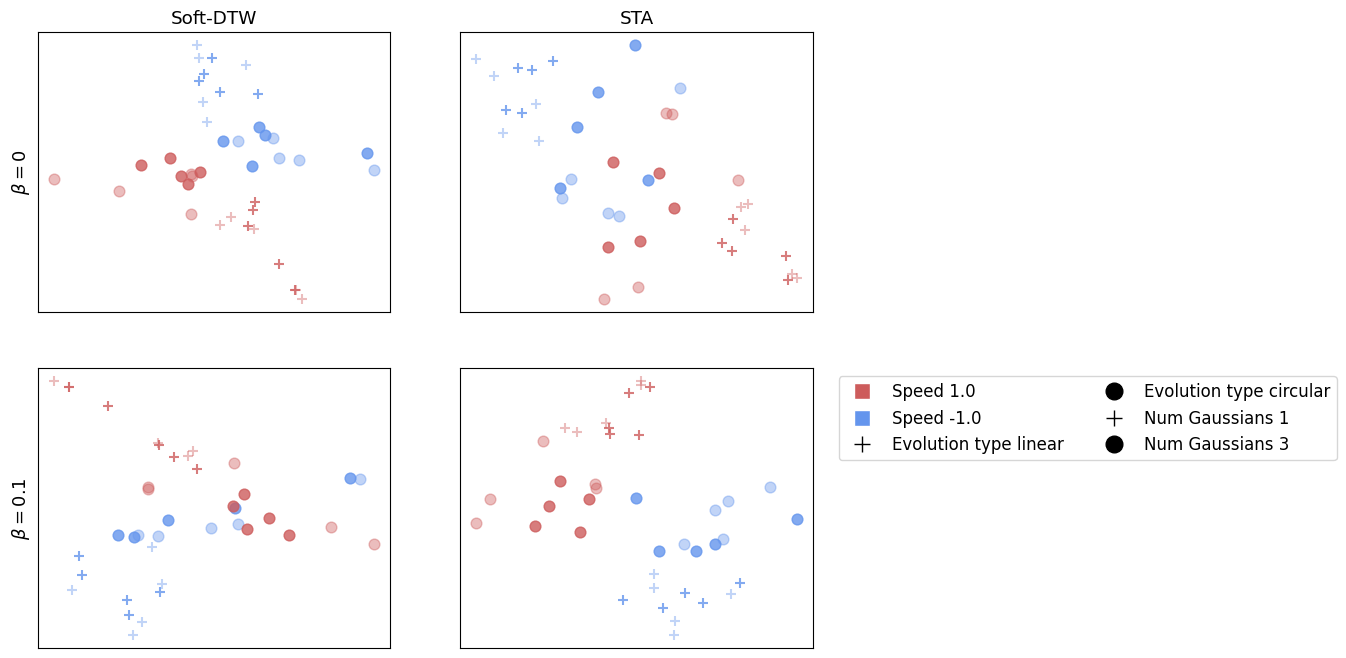

In [44]:
plot_tsne_results(data, num_samples_per_class,\
  num_timesteps, [0, 0.1], speeds, num_gaussians, evolution_types)

In [45]:
from matplotlib import pyplot as plt
import pickle
import numpy as np
from matplotlib.lines import Line2D

def plot_tsne_results(data, num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types):
    fontsize = 11
    params = {'axes.labelsize': fontsize + 2,
              'font.size': fontsize,
              'legend.fontsize': fontsize + 1,
              'xtick.labelsize': fontsize,
              'ytick.labelsize': fontsize,
              'pdf.fonttype': 42}
    plt.rcParams.update(params)

    expe_filename = get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types)
    data_expe_filename = f'data/{expe_filename}'
    fig_expe_filename_png = f'fig/{expe_filename.replace(".pkl", ".png")}'

    print('------filename of the figures of the experiment to copy in the plot cell below-----')
    print(fig_expe_filename_png)
    print('-------------------------------------')

    expe_file = open(data_expe_filename, "rb")
    experiment = pickle.load(expe_file)

    y_speed = experiment["y_speed"]
    print('y_speed:', y_speed)  
    y_evotype = experiment["y_evotype"]
    y_numgaussians = experiment["y_numgaussians"]

    methods = ["soft", "sta"]
    color_base = np.array(["indianred", "cornflowerblue"])
    colors = color_base[y_speed]
    marker_base = np.array(["+", "o"])
    markers = marker_base[y_evotype]

    titles = ["Soft-DTW", "STA"]
    color_names = ["Speed 1.0", "Speed -1.0"]
    marker_names = ["Evolution type linear", "Evolution type circular"]

    # Third label for number of Gaussians
    num_gaussians_names = ["Num Gaussians 1", "Num Gaussians 3"]

    legend_colors = [Line2D([0], [0], color="w", markerfacecolor=color, marker="s", label=name, markersize=12,)
                     for color, name in zip(color_base, color_names)]
    legend_marker = [Line2D([0], [0], color="w", markerfacecolor="k", markeredgecolor="k", linewidth=2,
                     marker=marker, markersize=12, label=name)
                     for marker, name in zip(marker_base, marker_names)]
    legend_num_gaussians = [Line2D([0], [0], color="w", markerfacecolor="k", markeredgecolor="k", linewidth=2,
                           marker=marker, markersize=12, label=name)
                           for marker, name in zip(marker_base, num_gaussians_names)]

    legend_colors.extend(legend_marker)
    legend_colors.extend(legend_num_gaussians)

    f, axes = plt.subplots(2, 2, figsize=(10, 8))

    for j, beta in enumerate(betas):
        for i, (method, title) in enumerate(zip(methods, titles)):
            method_data = experiment[method]
            tsne_data = method_data[beta]
            ax = axes[j, i]
            for point, color, marker, num_gaussian in zip(tsne_data, colors, markers, y_numgaussians):
                alpha = 0.4 if num_gaussian == 1 else 0.8  # Adjust alpha based on the number of Gaussians
                ax.scatter(point[0], point[1], color=color, s=60, marker=marker, alpha=alpha)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"{title} - Beta {beta}")
            if j == 1:
                ax.set_xlabel("Dimension 1")
            if i == 0:
                ax.set_ylabel("Dimension 2")

    ax.legend(handles=legend_colors, loc=2, ncol=2, bbox_to_anchor=[1.05, 1.0])

    # Save only in PNG format
    plt.savefig(fig_expe_filename_png, bbox_inches='tight')
    plt.show()

# Example usage
num_samples_per_class = 5
num_timesteps = 100
support_size = 100
num_gaussians = [1, 3]
evolution_types = ["linear", "circular"]
speeds = [1.0, -1.0]
seed = 42

data, y_speed, y_evotype, y_numgaussians = generate_gaussian_mixture_data(
    num_samples_per_class, num_timesteps, support_size, num_gaussians, evolution_types, speeds, seed=seed)

plot_tsne_results(data, num_samples_per_class, num_timesteps, [0, 0.1], speeds, num_gaussians, evolution_types)


------filename of the figures of the experiment to copy in the plot cell below-----
fig/tsne-gaussians_ns5_nt100_b0_0.1_s1.0_-1.0_ng1_3_linear_circular.png
-------------------------------------
y_speed: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
from matplotlib import pyplot as plt
import pickle
import numpy as np
from matplotlib.lines import Line2D

def plot_tsne_results(data, num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types):
    fontsize = 11
    params = {'axes.labelsize': fontsize + 2,
              'font.size': fontsize,
              'legend.fontsize': fontsize + 1,
              'xtick.labelsize': fontsize,
              'ytick.labelsize': fontsize,
              'pdf.fonttype': 42}
    plt.rcParams.update(params)

    expe_filename = get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types)
    data_expe_filename = f'data/{expe_filename}'
    fig_expe_filename_png = f'fig/{expe_filename.replace(".pkl", ".png")}'

    print('------filename of the figures of the experiment to copy in the plot cell below-----')
    print(fig_expe_filename_png)
    print('-------------------------------------')

    expe_file = open(data_expe_filename, "rb")
    experiment = pickle.load(expe_file)

    y_speed = experiment["y_speed"]
    y_evotype = experiment["y_evotype"]
    y_numgaussians = experiment["y_numgaussians"]

    methods = ["soft", "sta"]
    color_base = np.array(["indianred", "cornflowerblue"])
    colors = color_base[y_speed]
    marker_base = np.array(["+", "o"])
    markers = marker_base[y_evotype]

    titles = ["Soft-DTW", "STA"]
    color_names = ["Speed 1.0", "Speed -1.0"]
    marker_names = ["Evolution type linear", "Evolution type circular"]

    # Third label for number of Gaussians
    num_gaussians_names = ["Num Gaussians 1", "Num Gaussians 3"]

    legend_colors = [Line2D([0], [0], color="w", markerfacecolor=color, marker="s", label=name, markersize=12,)
                     for color, name in zip(color_base, color_names)]
    legend_marker = [Line2D([0], [0], color="w", markerfacecolor="k", markeredgecolor="k", linewidth=2,
                     marker=marker, markersize=12, label=name)
                     for marker, name in zip(marker_base, marker_names)]
    legend_num_gaussians = [Line2D([0], [0], color="w", markerfacecolor="k", markeredgecolor="k", linewidth=2,
                           marker=marker, markersize=12, label=name)
                           for marker, name in zip(marker_base, num_gaussians_names)]

    legend_colors.extend(legend_marker)
    legend_colors.extend(legend_num_gaussians)

    f, axes = plt.subplots(len(betas), 2, figsize=(6, 3 * len(betas)))

    for j, (ax_row, beta) in enumerate(zip(axes, betas)):
        for i, (ax, method, title) in enumerate(zip(ax_row, methods, titles)):
            method_data = experiment[method]
            tsne_data = method_data[beta]
            for point, color, marker, num_gaussian in zip(tsne_data, colors, markers, y_numgaussians):
                alpha = 0.4 if num_gaussian == 1 else 0.8  # Adjust alpha based on the number of Gaussians
                ax.scatter(point[0], point[1], color=color, s=60, marker=marker, alpha=alpha)
            ax.set_xticks([])
            ax.set_yticks([])
            if i == 0:
                ax.set_ylabel(r"$\beta = %s$" % (np.round(beta, 1)))
            if j == 0:
                ax.set_title(title)

    ax.legend(handles=legend_colors, loc=2, ncol=2, bbox_to_anchor=[-0.9, 0.0])

    # Save only in PNG format
    plt.savefig(fig_expe_filename_png)
    plt.show()

# Example usage
num_samples_per_class = 5
num_timesteps = 100
support_size = 100
num_gaussians = [1, 3]
evolution_types = ["linear", "circular"]
speeds = [1.0, -1.0]
seed = 42

data, y_speed, y_evotype, y_numgaussians = generate_gaussian_mixture_data(
    num_samples_per_class, num_timesteps, support_size, num_gaussians, evolution_types, speeds, seed=seed)

plot_tsne_results(data, num_samples_per_class, num_timesteps, [0, 0.1], speeds, num_gaussians, evolution_types)


------filename of the figures of the experiment to copy in the plot cell below-----
fig/tsne-gaussians_ns5_nt100_b0_0.1_s1.0_-1.0_ng1_3_linear_circular.png
-------------------------------------


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
from matplotlib import pyplot as plt
import pickle
import numpy as np
from matplotlib.lines import Line2D

fontsize = 11
params = {'axes.labelsize': fontsize + 2,
          'font.size': fontsize,
          'legend.fontsize': fontsize + 1,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'pdf.fonttype': 42}
plt.rcParams.update(params)

expe_filename = get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types)
data_expe_filename = f'data/{expe_filename}'
fig_expe_filename = f'fig/{expe_filename.replace(".pkl", ".pdf")}'
fig_expe_filename_png = f'fig/{expe_filename.replace(".pkl", ".png")}'

print('------filename of the figures of the experiment to copy in the plot cell below-----')
print(fig_expe_filename)
print(fig_expe_filename_png)
print('-------------------------------------')

expe_file = open(data_expe_filename, "rb")
experiment = pickle.load(expe_file)

y_speed = experiment["y_speed"]
y_evotype = experiment["y_evotype"]

methods = ["soft", "sta"]
betas = experiment["betas"]
color_base = np.array(["indianred", "cornflowerblue"])
colors = color_base[y_speed]
marker_base = np.array(["+", "o"])
markers = marker_base[y_evotype]

titles = ["Soft-DTW", "STA"]
color_names = ["Speed 5", "Speed 10"]
marker_names = ["Evolution type 0", "Evolution type 10"]

legend_colors = [Line2D([0], [0], color="w", markerfacecolor=color, marker="s", label=name, markersize=12,)
                 for color, name in zip(color_base, color_names)]
legend_marker = [Line2D([0], [0], color="w", markerfacecolor="k", markeredgecolor="k", linewidth=2,
                 marker=marker, markersize=12, label=name)
                 for marker, name in zip(marker_base, marker_names)]
legend_colors.extend(legend_marker)

f, axes = plt.subplots(len(betas), 2, figsize=(6, 3 * len(betas)))

for j, (ax_row, beta) in enumerate(zip(axes, betas)):
    for i, (ax, method, title) in enumerate(zip(ax_row, methods, titles)):
        method_data = experiment[method]
        tsne_data = method_data[beta]
        for point, color, marker in zip(tsne_data, colors, markers):
            ax.scatter(point[0], point[1], color=color, s=60, marker=marker, alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_ylabel(r"$\beta = %s$" % (np.round(beta, 1)))
        if j == 0:
            ax.set_title(title)

ax.legend(handles=legend_colors, loc=2, ncol=2, bbox_to_anchor=[-0.9, 0.0])

if len(betas) > 2:
    plt.savefig(fig_expe_filename)
else:
    plt.savefig(fig_expe_filename)

# Optional: Save a PNG version of the figure
plt.savefig(fig_expe_filename_png)
plt.show()


------filename of the figures of the experiment to copy in the plot cell below-----
fig/tsne-gaussians_ns5_nt100_b0_0.1_s1.0_-1.0_ng1_3_linear_circular.pdf
fig/tsne-gaussians_ns5_nt100_b0_0.1_s1.0_-1.0_ng1_3_linear_circular.png
-------------------------------------


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices